# Exploration of PCA and POD on Sentinel-2 Data for Surface Melt Estimation

## Gabrielle Hobson
## SIO 236 Term Paper Project

### Loading required libraries

In [1]:
import numpy as np
from numpy import sin, cos
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
#from PIL import Image
import rasterio
from time import perf_counter
import pandas as pd
from sklearn.cluster import KMeans

### Colors for plotting 

In [2]:
color_1 = (213/255,29/255,38/255)
color_2 = (251/255,173/255,104/255)
color_3 = (49/255,124/255,180/255)
color_4 = (94/255,63/255,151/255)

### Load data from csv files

In [3]:
filepaths = ["AOT_data.csv","b2_data.csv","b3_data.csv","b4_data.csv","b5_data.csv","b6_data.csv","b7_data.csv","b8A_data.csv","b11_data.csv","b12_data.csv","SCL_data.csv","TCI_data.csv","WVP_data.csv"]
data = np.zeros((np.shape(pd.read_csv(filepaths[0]))[0],np.shape(pd.read_csv(filepaths[0]))[1],13))
for k in range((len(filepaths))):
    data[:,:,k] = pd.read_csv(filepaths[k]).values

### Center the data

In [4]:
for k in range((np.shape(data)[2])):
    data[:,:,k] = data[:,:,k] - np.mean(np.mean(data[:,:,k]))

### Plotting the rgb bands

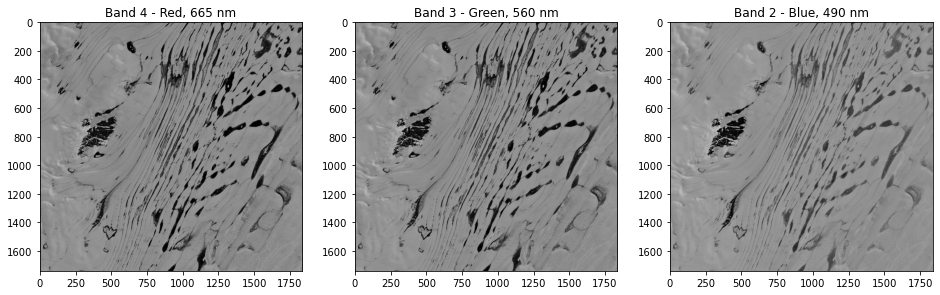

In [5]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(data[:,:,4],cmap=cm.gray)
plt.title('Band 4 - Red, 665 nm')
plt.subplot(1,3,2)
plt.imshow(data[:,:,3],cmap=cm.gray)
plt.title('Band 3 - Green, 560 nm')
plt.subplot(1,3,3)
plt.imshow(data[:,:,2],cmap=cm.gray)
plt.title('Band 2 - Blue, 490 nm')
plt.show()

### Computing covariance matrix, eigenvalues, and eigenvectors

In [6]:
# computing cov matrix
C = np.zeros((np.shape(data)[2],np.shape(data)[2]))
for i in np.arange(0,np.shape(data)[2]):
    for j in np.arange(0,np.shape(data)[2]):
        C[i,j] = np.mean(np.mean(data[:,:,i]*data[:,:,j]))
        
# computing eigenvalues and eigenvectors
[D,V] = np.linalg.eig(C)

### Creating principal components

In [7]:
P = np.zeros([np.shape(data)[0],np.shape(data)[1],np.shape(data)[2]]);
for i in np.arange(0,np.shape(data)[2]):
    for j in np.arange(0,np.shape(data)[2]):
        P[:,:,j] = P[:,:,j] + V[i,j]*data[:,:,i]

### Visualizing principal components

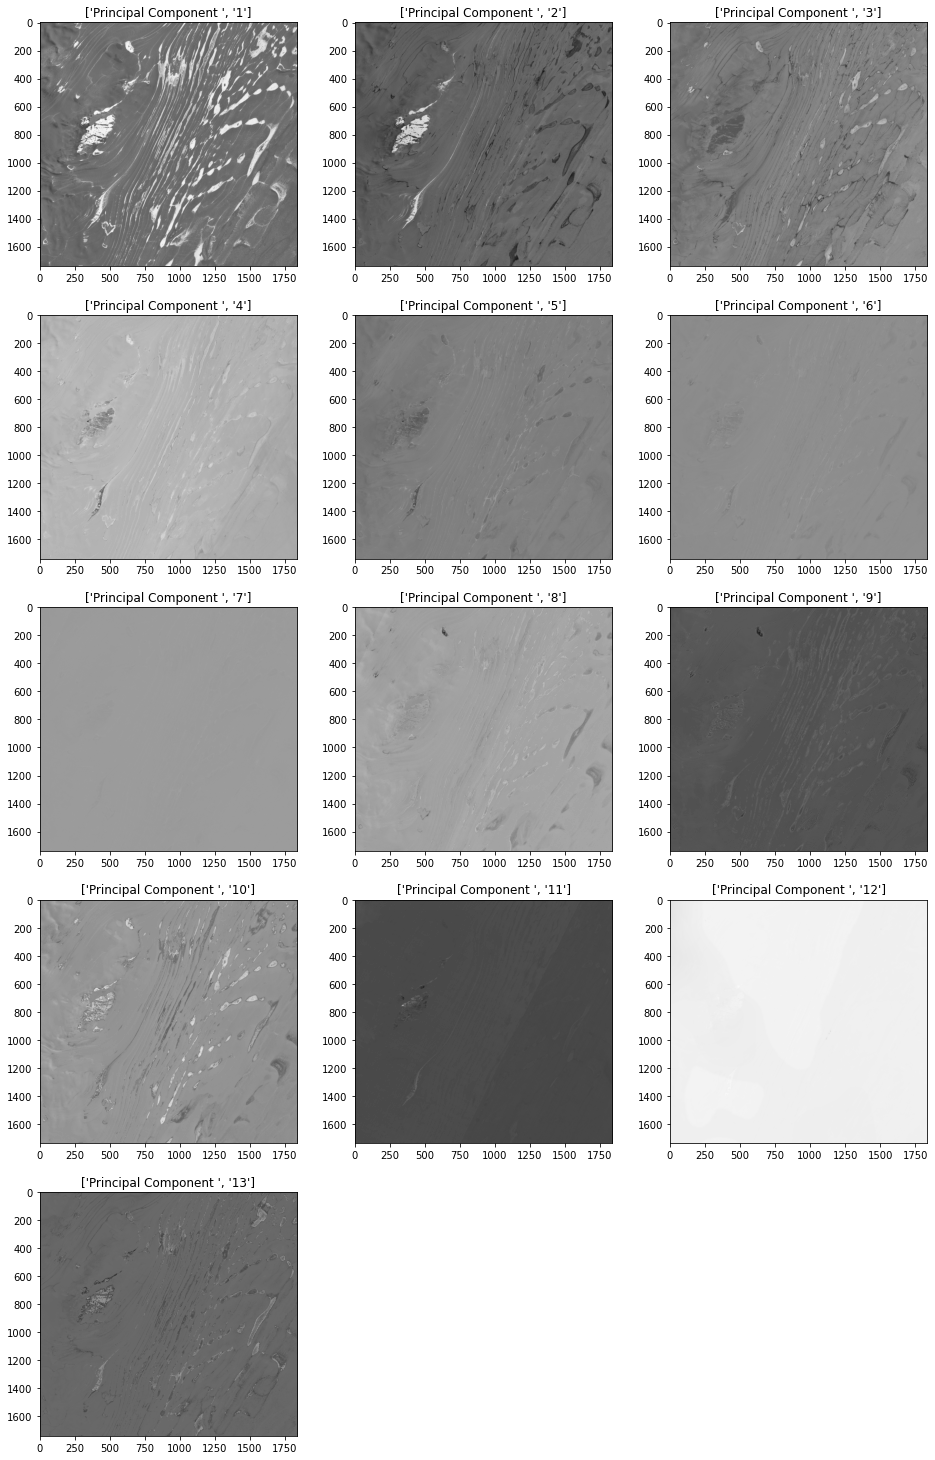

In [8]:
plt.figure(figsize=(16,26))
for i in range((np.shape(data)[2])):
    plt.subplot(5,3,i+1)
    plt.imshow(P[:,:,i],cmap=cm.gray,vmin=np.min(np.min(P[:,:,i])),vmax=np.max(np.max(P[:,:,i])))
    plt.title(['Principal Component ',str(i+1)])

## K-Means clustering

### Starting with first two principal components. The first principal component seems to distinguish melt ponds and rock from ice surface. The second PC distinguishes rock from everything else.  

### Concatenating and reshaping the two principal components into a tall, skinny matrix. 

In [9]:
composed = [P[:,:,0].reshape(-1), P[:,:,1].reshape(-1)]
composed = np.transpose(composed)
np.shape(composed)

(3194543, 2)

### An elbow plot can help us determine how many clusters are ideal to use. From the below plot and my understanding of what I want to compute, I choose to use two clusters. 

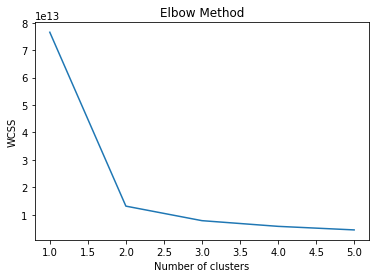

In [10]:
wcss = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=200, n_init=10, random_state=0)
    kmeans.fit(composed)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 6), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Computing the two clusters and visualizing

In [11]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=200, n_init=10, random_state=0)
kmeans.fit(composed)
y_kmeans = kmeans.predict(composed)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

result_pc1pc2 = labels.reshape((P[:,:,0].shape))

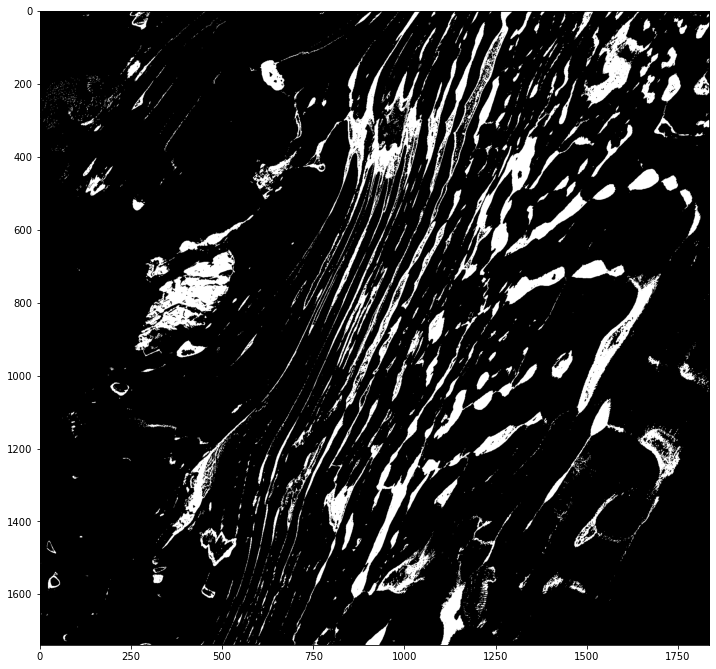

In [12]:
plt.figure(figsize=(12,12))
plt.imshow(result_pc1pc2, cmap=cm.gray)

### Repeating the process with just the second PC

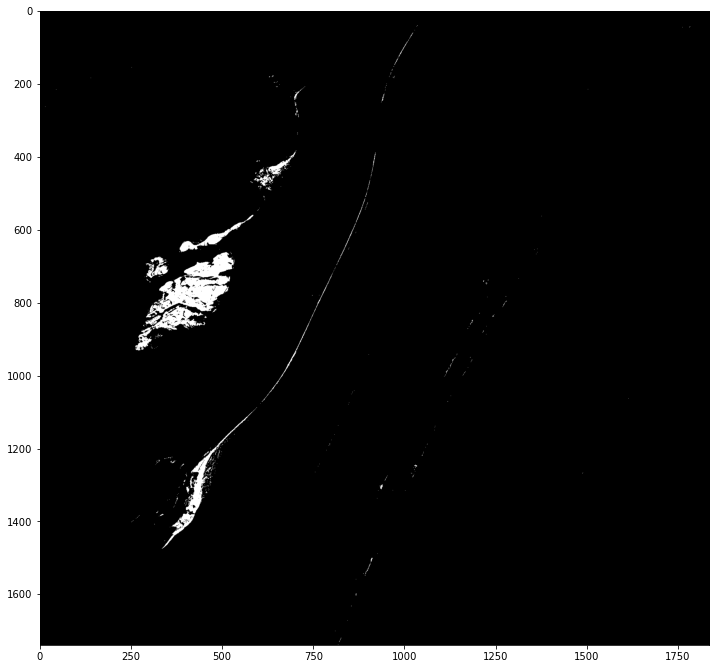

In [13]:
data_pc2 = [P[:,:,1].reshape(-1)]
data_pc2 = np.transpose(data_pc2)

kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=200, n_init=10, random_state=0)
kmeans.fit(data_pc2)
y_kmeans = kmeans.predict(data_pc2)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

result_pc2 = labels.reshape((P[:,:,0].shape))

plt.figure(figsize=(12,12))
plt.imshow(result_pc2, cmap=cm.gray)

### Subtracting the second result from the first to get just the melt.

Some values are -1 when this is done, this is because something previously classified as ice in result_pc1pc2 then gets classified as rock in result_pc2. Either way, I figure that neither classification is surface melt, so I will set these pixels to 0 (not surface melt). 

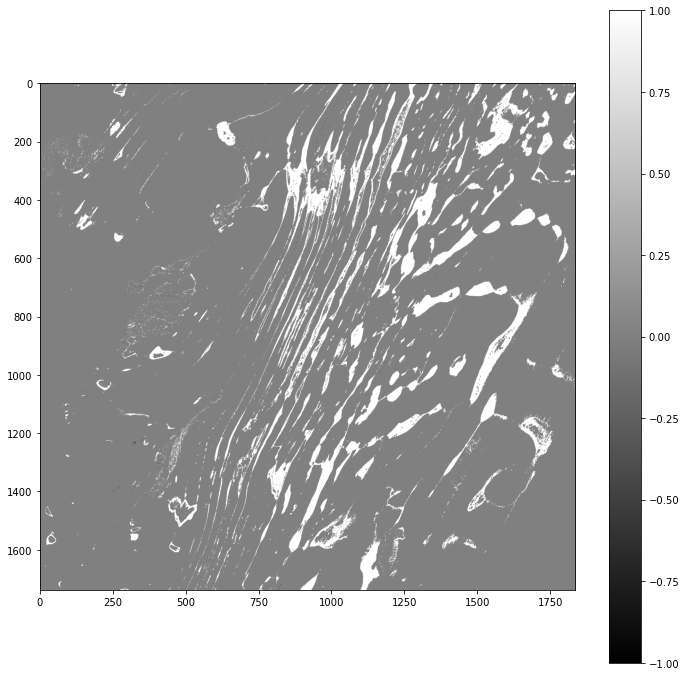

In [14]:
result_melt = result_pc1pc2 - result_pc2

plt.figure(figsize=(12,12))
plt.imshow(result_melt, cmap=cm.gray)
plt.colorbar()

In [15]:
min_misclassification = 0
for k in range(np.shape(result_melt)[0]):
    for j in range(np.shape(result_melt)[1]):
        if result_melt[k,j] == -1:
            min_misclassification += 1
            
print('min_misclassification: ', min_misclassification)

min_misclassification:  365


### Reassigning misclassified pixels to be 0 (not melt). 

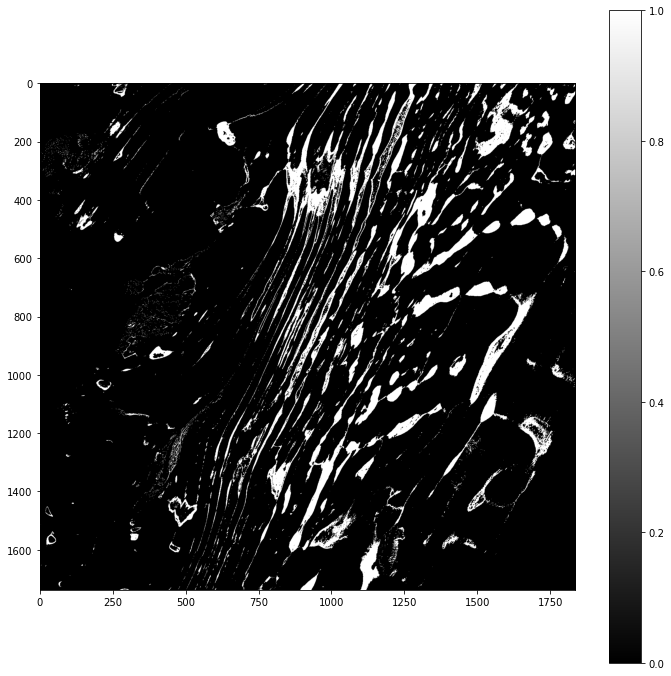

In [16]:
result_melt_clean = np.where(result_melt==-1,0,result_melt)

plt.figure(figsize=(12,12))
plt.imshow(result_melt_clean, cmap=cm.gray)
plt.colorbar()

### How many pixels are classified as melt water?

In [17]:
count_melt_pix = np.sum(np.sum(result_melt_clean))
print('Number of melt water pixels: ', count_melt_pix)
print('Fraction of melt water pixels: ', count_melt_pix/np.prod(result_melt_clean.shape))

Number of melt water pixels:  305011
Fraction of melt water pixels:  0.09547875862056013


### Next Steps

- Improve data retrieval
- Compare to existing algorithms
- Compute surface melt fraction in m^2 rather than pixels
- Other suggestions?